In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
import os
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(1, './modules/')
import pydelfi_t1.priors as priors
from smt.sampling_methods import LHS

#importing simulation modules and parameters file______
import simulator as sims
data_generation=sims.simulations()
from set_params import *

data_generation=sims.simulations()
#______________________________________________________
    
%matplotlib inline

import tensorflow as tf
print("TensorFlow {}\nnumpy {}".format(
    tf.__version__, np.__version__))

TensorFlow 1.15.0
numpy 1.17.2


## Simulating real data samples

In [2]:
n_sets = 1

In [3]:
new_realdata = True

if new_realdata == True:
    if not os.path.exists('{}'.format(pathtorealsamples)):
        os.makedirs('{}'.format(pathtorealsamples))
    print('APPLYING LATIN HYPERCUBE')

    sampling = LHS(xlimits=np.array([[65,75],[-0.7,-0.3]]))
    draws = sampling(n_sets)
    
    real_data = np.zeros((n_sets,(n_obs)*n_sources))
    
    for i in range (n_sets):
        theta=np.array([draws[i][0],draws[i][1]])
        sim = data_generation.data_simulator(theta = theta)
        real_data[i] = sim    

    np.savetxt('{}'.format(pathtorealsamples)+'/multi_thetas{}.txt'.format(ref_filename),draws)    
    np.savetxt('{}'.format(pathtorealsamples)+'/multi_randomdata{}.txt'.format(ref_filename),real_data)

APPLYING LATIN HYPERCUBE


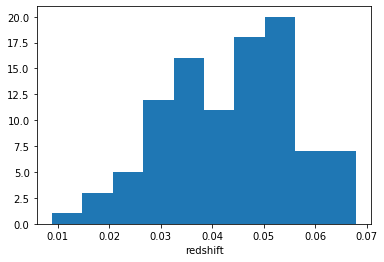

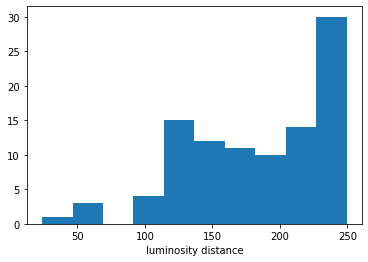

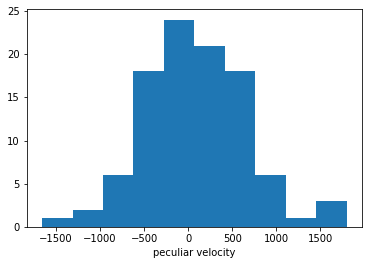

In [4]:
observables = ['redshift','luminosity distance','peculiar velocity']
for i in range (len(observables)):
    plt.hist(real_data[0,i*100:(i+1)*100])
    plt.xlabel(observables[i])
    plt.show()

## Simulating training data for the regression neural network

In [5]:
new_NN_data = True

if new_NN_data == True:
    data_generation.NN_datasets()


computing training simulations
(5, 1000, 302)
0/1000 thetas done
time for all sims 0:00:00
100/1000 thetas done
time for all sims 0:00:09
200/1000 thetas done
time for all sims 0:00:19
300/1000 thetas done
time for all sims 0:00:32
400/1000 thetas done
time for all sims 0:00:42
500/1000 thetas done
time for all sims 0:00:54
600/1000 thetas done
time for all sims 0:01:06
700/1000 thetas done
time for all sims 0:01:20
800/1000 thetas done
time for all sims 0:01:34
900/1000 thetas done
time for all sims 0:01:46
computing validation simulations
(2, 1000, 302)
0/1000 thetas done
time for all sims 0:00:01
100/1000 thetas done
time for all sims 0:00:05
200/1000 thetas done
time for all sims 0:00:11
300/1000 thetas done
time for all sims 0:00:16
400/1000 thetas done
time for all sims 0:00:21
500/1000 thetas done
time for all sims 0:00:26
600/1000 thetas done
time for all sims 0:00:30
700/1000 thetas done
time for all sims 0:00:34
800/1000 thetas done
time for all sims 0:00:39
900/1000 thetas d

## Simulating the prerun simulation for LFI computations 

In [6]:
new_prerunsims = True
n_sims = 2000

if new_prerunsims == True:
    
    pathlib.Path('{}'.format(pathtopydelfiprerunsims)).mkdir(parents=True, exist_ok=True)

    # drawing thetas

    print('APPLYING UNIFORM PRIOR')
    prior_distr = priors.Uniform(lower, upper)     

    draws = np.zeros((n_sims,2))
    for i in range (n_sims):
        draws[i]=prior_distr.draw()
    
    np.savetxt('{}'.format(pathtopydelfiprerunsims)+'/prerun_thetas{}.txt'.format(ref_filename),draws) 

    #sims

    prerun_sims = np.zeros((n_sims,(n_obs)*n_sources))
    for i in range (n_sims):
        theta=np.array([draws[i][0],draws[i][1]])
        sim = data_generation.data_simulator(theta = theta)
        prerun_sims[i] = sim  
    
    np.savetxt('{}'.format(pathtopydelfiprerunsims)+'/prerun_sims{}.txt'.format(ref_filename),prerun_sims)

    print(prerun_sims.shape)
    print(draws.shape)

APPLYING UNIFORM PRIOR
(2000, 300)
(2000, 2)


## Regression Neural Network 

In [2]:
%cd ./modules/

/home/francesca/Desktop/PhD_project/LFIH0_BNS/tutorial/modules


In [11]:
if sys.version[0]==3:
    pathlib.Path('{}'.format(pathtoNNmodels)).mkdir(parents=True, exist_ok=True) 
else:
    if not os.path.exists('{}'.format(pathtoNNmodels)):
        os.makedirs('{}'.format(pathtoNNmodels))

%run NN.py

____PROCESS0 for [l1,bs,lr]=[array([0.0001]), array([100]), array([0.0001])]have been set____
(5000, 300)
(2000, 300)
Restoring model weights from the end of the best epoch.
Epoch 01051: early stopping
Model 1 has been stored
Restoring model weights from the end of the best epoch.
Epoch 01155: early stopping
Model 2 has been stored
Restoring model weights from the end of the best epoch.
Epoch 01269: early stopping
Model 3 has been stored
Restoring model weights from the end of the best epoch.
Epoch 01037: early stopping
Model 4 has been stored
Restoring model weights from the end of the best epoch.
Epoch 00922: early stopping
Model 5 has been stored
Training process is complete and models have been stored


## STAN

In [2]:
#%cd ./modules/

/home/francesca/Desktop/PhD_project/LFIH0_BNS/tutorial/modules


In [4]:
for k in range (1):
    np.save('real_data_element',k)
    %run STAN.py
os.remove("real_data_element.npy")

tensorflow version 1.15.0
STAN_scripts/N_bar_numerical_coefficients_3Dsel_zmin0.0.txt


0 (20000, 2)
Removed no burn in


## Likelihood free inference

In [2]:
%cd ./modules/

/home/francesca/Desktop/PhD_project/LFIH0_BNS/tutorial/modules


In [3]:
%run LFI.py

Using TensorFlow backend.


stacking weights already computed
____PROCESS0 for NN_filename=MSE_ns5000_2LR0.1_128_128_bs100_lr0.0001_l10.0001have been set____
validation residuals already computed
prerun sims already compressed
SS vs params already plotted
[0.4831714  0.59811741]
PYDELFI: APPLYING GAUSSIAN PRIOR
____PROCESS0 for NN_filename=[array([0.0001]), array([100]), array([0.0001])]has set and started pydelfi____


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

____PROCESS0 for NN_filename=[array([0.0001]), array([100]), array([0.0001])]has finished training pydelfi____
Removed no burn in
Removed no burn in
____PROCESS0 for NN_filename=[array([0.0001]), array([100]), array([0.0001])]has finished____
